# Documentation by example for `shap.plots.text`

This notebook is designed to demonstrate (and so document) how to use the `shap.plots.text` function. It uses a distilled PyTorch BERT model from the transformers package to do sentiment analysis of IMDB movie reviews.

Note that the prediction function we define takes a list of strings and returns a logit value for the positive class.

<hr>
<center style="color: red">
<b>Warning!</b> This notebook documents the new SHAP API, and that API is still stablizing over the coming weeks.
    </center>
<hr>

In [1]:
import shap
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10])

explainers.Partition is still in an alpha state, so use with caution...
Partition explainer: 11it [00:32,  2.95s/it]


## Single instance text plot

When we pass a single instance to the text plot we get the importance of each token overlayed on the original text that corresponds to that token. Red regions correspond to parts of the text that increase the output of the model when they are included, while blue regions decrease the output of the model when they are included. In the context of the sentiment analysis model here red corresponds to a more positive review and blue a more negative review.

Note that importance values returned for text models are often hierarchical and follow the structure of the text. Nonlinear interactions between groups of tokens are often saved and can be used during the plotting process. If the Explanation object passed to the text plot has a `.hierarchical_values` attribute, then small groups of tokens with strong non-linear effects among them will be auto-merged together to form coherent chunks. When the `.hierarchical_values` attribute is present it also means that the explainer may not have completely enumerated all possible token perturbations and so has treated chunks of the text as essentially a single unit. This happens since we often want to explain a text model while evaluating it fewer times than the numbers of tokens in the document. Whenever a region of the input text is not split by the explainer, it is show by the text plot as a single unit.

The force plot above the text is designed to provide an overview of how all the parts of the text combine to produce the model's output. See the [force plot]() notebook for more details, but the general structure of the plot is positive red features "pushing" the model output higher while negative blue features "push" the model output lower. The force plot provides much more quantitative information than the text coloring. Hovering over a chuck of text will underline the portion of the force plot that corresponds to that chunk of text, and hovering over a portion of the force plot will underline the corresponding chunk of text.

Note that clicking on any chunk of text will show the sum of the SHAP values attributed to the tokens in that chunk (clicked again will hide the value).

In [2]:
# plot the first sentence's explanation
shap.plots.text(shap_values[3])

## Multiple instance text plot

When we pass a multi-row explanation object to the text plot we get the single instance plots for each input instance scaled so they have consistent comparable x-axis and color ranges.

In [3]:
# plot the first sentence's explanation
shap.plots.text(shap_values[:3])

## Summarizing text explanations

While plotting several instance-level explanations using the text plot can be very informative, sometime you want global summaries of the impact of tokens over the a large set of instances. See the [Explanation object]() documentation for more details, but you can easily summarize the importance of tokens in a dataset by collapsing a multi-row explanation object over all it's rows (in this case by summing). Doing this treats every text input token type as a feature, so the collapsed Explanation object will have as many columns as there were unique tokens in the orignal multi-row explanation object. If there are hierarchical values present in the Explanation object then any large groups are divided up and each token in the gruop is given an equal share of the overall group importance value.

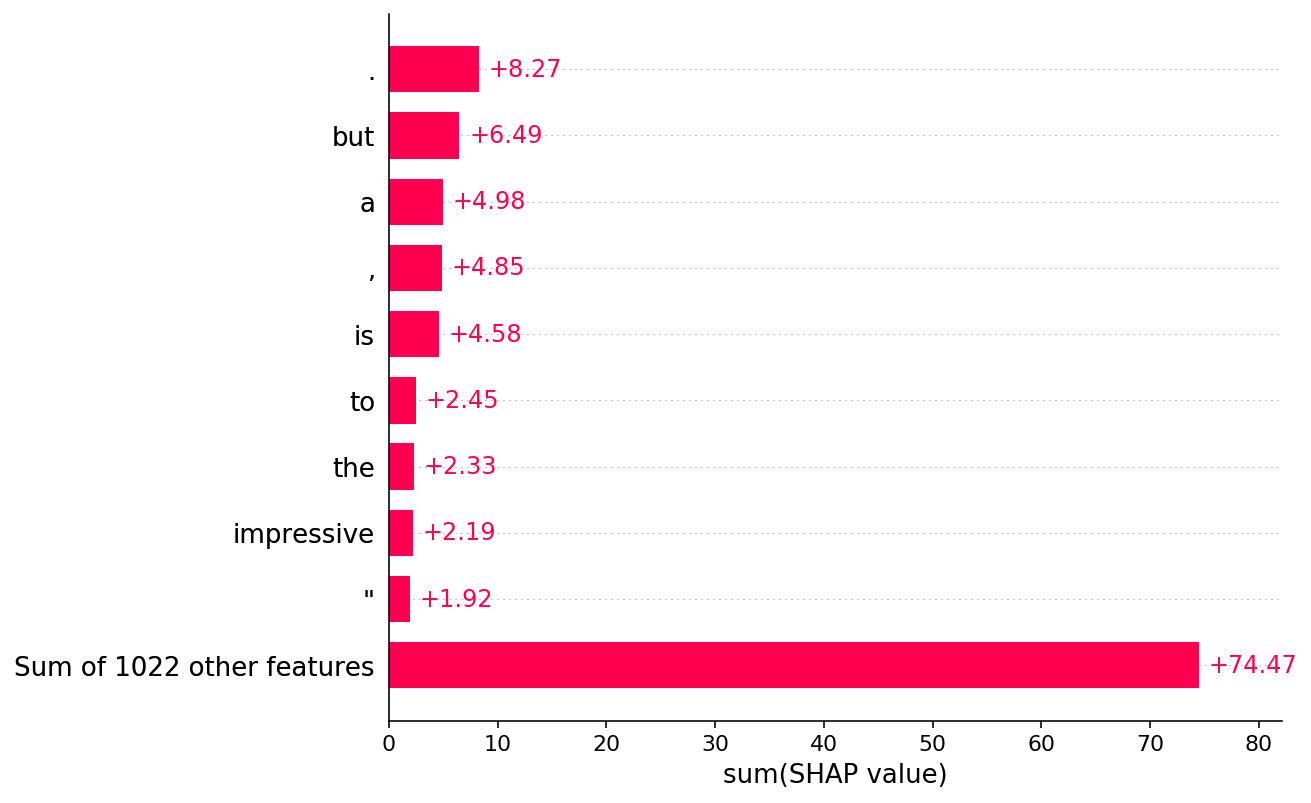

In [4]:
shap.plots.bar(shap_values.abs.sum(0))

Note that how you summarize the importance of features can make a big difference. In the plot above the `a` token was very importance both because it had an impact on the model, and because it was very common. Below we instead summize the instances using the `max` function to see the largest impact of a token in any instance.

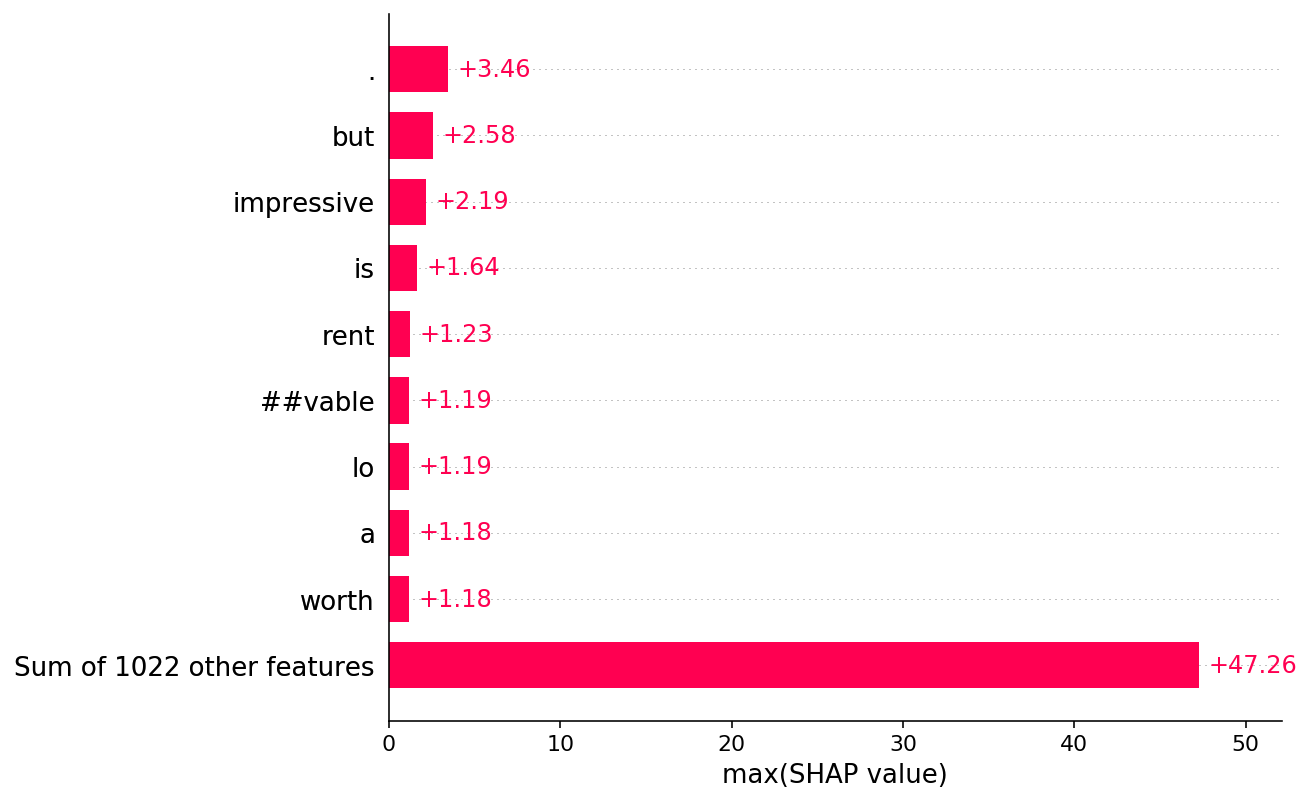

In [5]:
shap.plots.bar(shap_values.abs.max(0))

You can also slice out a single token from all the instances by using that token as an input name (note that the gray values to the left of the input names are the original text that the token was generated from).

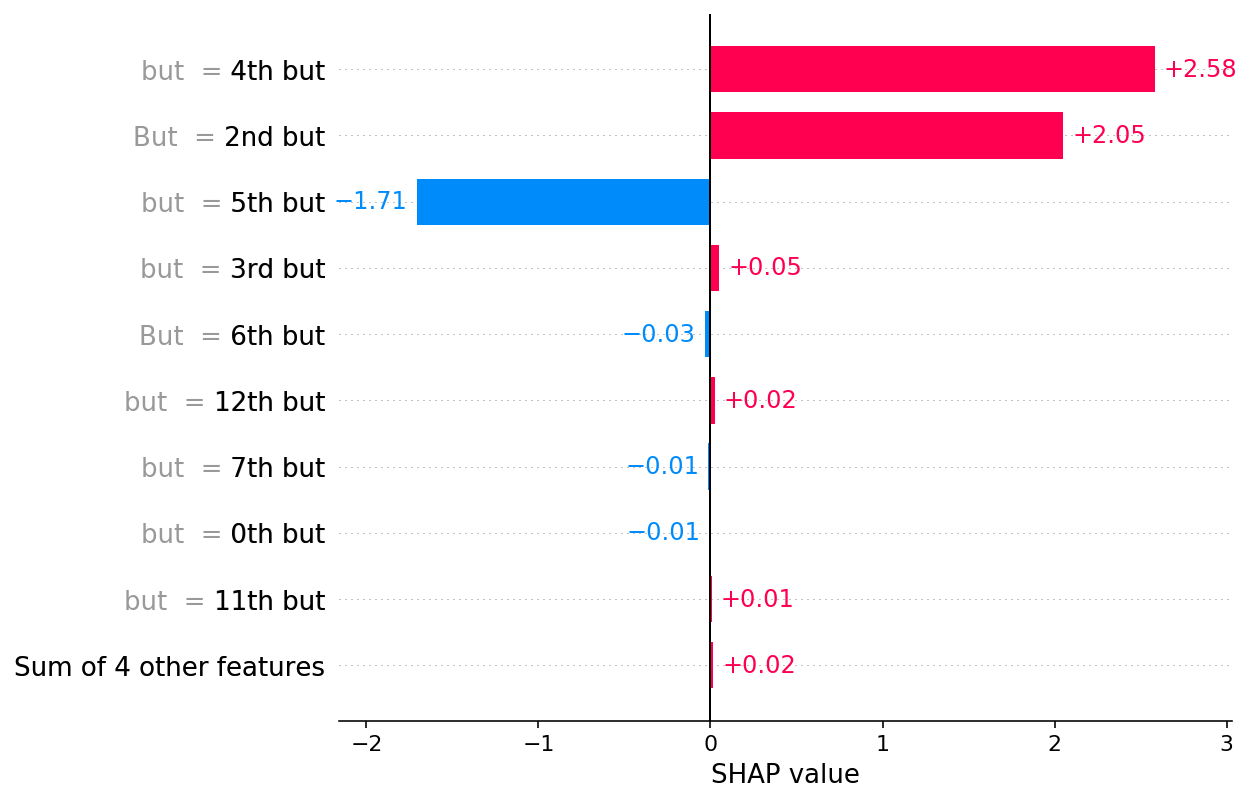

In [6]:
shap.plots.bar(shap_values[:,"but"])

## Why the base values can be differenent for each sample

The base values for the explanations above is different for each instance. This is because the default masking behavior when using a transformers tokenizer as the masker is to replace tokens with the `mask_token` defined by the tokenizer. This means that "removing" (i.e. masking) all the tokens in a document still preserves the length of the document, just with all the token replaced by the mask token. It turns out that the model assumes that longer reviews are in general more positive that shorter reviews, so before we even know anything about the content of the review the model the model is biased by the review length. We could create consistent base values by modeling review length as another input feature (this is not built in to SHAP yet).

To see how the model output is biased by length we plot the output score for inputs of different numbers of mask tokens:

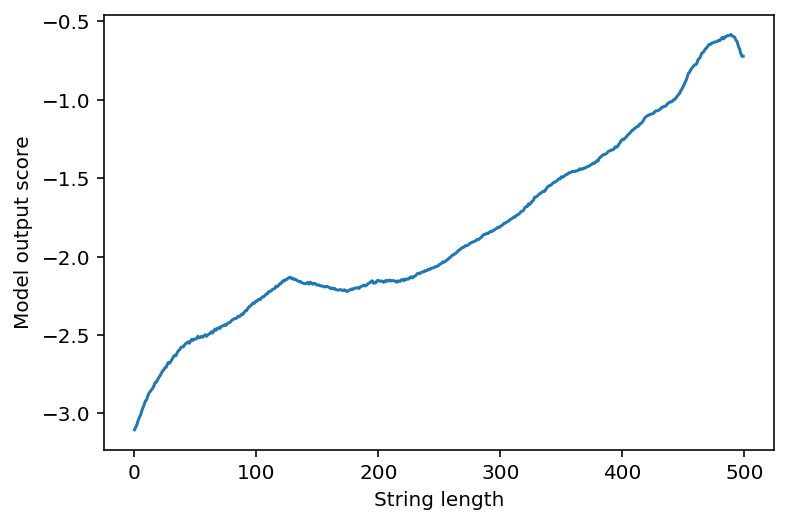

In [7]:
import matplotlib.pyplot as pl
pl.plot([f(["[MASK]" * i]) for i in range(500)])
pl.xlabel("String length")
pl.ylabel("Model output score")
pl.show()

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 